#### Movie sentiment model using glove embeddings

In [1]:
import pandas as pd
from numpy import asarray
from numpy import zeros
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle

In [2]:
def getGloveEmbeddings(glovefolderpath):
    print("---------------------- Getting Glove Embeddings -------------------------\n")
    embeddings_dictionary = dict()
    glove_file = open(f"{glovefolderpath}", encoding="utf8")
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    glove_file.close()
    print("----------------------  -------------------------\n")
    return embeddings_dictionary

In [3]:
glove_folder=r'D:/STUDY/Sem3/deeplearning/glove.6B/glove.6B.50d.txt'
maxlen = 50

In [4]:
dataset =  pd.read_csv('SMSSpamCollection.txt',sep='\t',names=['label','message'])

In [5]:
dataset['label'] = dataset['label'].map( {'spam': 1, 'ham': 0} )
X = dataset['message'].values
y = dataset['label'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
tokeniser = tf.keras.preprocessing.text.Tokenizer()
tokeniser.fit_on_texts(X_train)

# Save the tokenizer using pickle
with open('tokenizer_smsglove.pickle', 'wb') as handle:
    pickle.dump(tokeniser, handle, protocol=pickle.HIGHEST_PROTOCOL)

X_train = tokeniser.texts_to_sequences(X_train)
X_test = tokeniser.texts_to_sequences(X_test)
vocab_size = len(tokeniser.word_index) + 1
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

In [8]:
embeddings_dictionary=getGloveEmbeddings(glove_folder)
embedding_matrix = zeros((vocab_size, maxlen))
for word, index in tokeniser.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

---------------------- Getting Glove Embeddings -------------------------

----------------------  -------------------------



In [9]:
model=tf.keras.models.Sequential([
   tf.keras.layers.Embedding(input_dim=vocab_size,output_dim= maxlen, weights=[embedding_matrix], input_length=maxlen , trainable=False),
   tf.keras.layers.LSTM(maxlen),
   tf.keras.layers.Dense(1, activation='sigmoid')
])  

In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            375100    
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 395351 (1.51 MB)
Trainable params: 20251 (79.11 KB)
Non-trainable params: 375100 (1.43 MB)
_________________________________________________________________
None


In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='min', patience=10)

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history=model.fit(x=X_train,
        y=y_train,
        epochs=50,
        callbacks=[early_stop],
        validation_split=0.2
         )

Epoch 1/50
98/98 [==============================] - 4s 18ms/step - loss: 0.4303 - accuracy: 0.8673 - val_loss: 0.4185 - val_accuracy: 0.8538
Epoch 2/50
98/98 [==============================] - 1s 13ms/step - loss: 0.3880 - accuracy: 0.8689 - val_loss: 0.4169 - val_accuracy: 0.8538
Epoch 3/50
98/98 [==============================] - 1s 14ms/step - loss: 0.3129 - accuracy: 0.8862 - val_loss: 0.1761 - val_accuracy: 0.9372
Epoch 4/50
98/98 [==============================] - 1s 14ms/step - loss: 0.1514 - accuracy: 0.9513 - val_loss: 0.1382 - val_accuracy: 0.9564
Epoch 5/50
98/98 [==============================] - 2s 16ms/step - loss: 0.1234 - accuracy: 0.9635 - val_loss: 0.1296 - val_accuracy: 0.9538
Epoch 6/50
98/98 [==============================] - 2s 18ms/step - loss: 0.0930 - accuracy: 0.9692 - val_loss: 0.1117 - val_accuracy: 0.9628
Epoch 7/50
98/98 [==============================] - 2s 18ms/step - loss: 0.0841 - accuracy: 0.9744 - val_loss: 0.1448 - val_accuracy: 0.9577
Epoch 8/50
98

In [14]:
def c_report(y_true, y_pred):
   print("Classification Report")
   print(classification_report(y_true, y_pred))
   acc_sc = accuracy_score(y_true, y_pred)
   print(f"Accuracy : {str(round(acc_sc,2)*100)}")
   return acc_sc
def plot_confusion_matrix(y_true, y_pred):
   mtx = confusion_matrix(y_true, y_pred)
   sns.heatmap(mtx, annot=True, fmt='d', linewidths=.5, cmap="Blues", cbar=False)
   plt.ylabel('True label')
   plt.xlabel('Predicted label')
   plt.show()

53/53 [==============================] - 1s 5ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1448
           1       0.96      0.89      0.93       224

    accuracy                           0.98      1672
   macro avg       0.97      0.94      0.96      1672
weighted avg       0.98      0.98      0.98      1672

Accuracy : 98.0


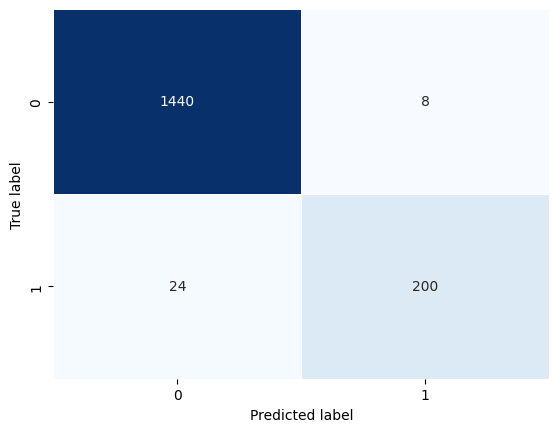

In [15]:
preds = (model.predict(X_test) > 0.5).astype("int32")
c_report(y_test, preds)
plot_confusion_matrix(y_test, preds)

In [16]:
# Save the model
model.save('sms_sentiment_model.h5')

d:\STUDY\Sem3\deeplearning\DLENV\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
sms_sentiment_model=tf.keras.models.load_model('sms_sentiment_model.h5')

In [18]:
def predict_sms_sentiment(message):
    sequence = tokeniser.texts_to_sequences([message])
    sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post', maxlen=maxlen)
    prediction = sms_sentiment_model.predict(sequence)[0, 0]
    if prediction > 0.5:
        return 'Spam'
    else:
        return 'Not spam'



In [19]:
# Example usage:
sample_message = "Check out this amazing offer!"
result = predict_sms_sentiment(sample_message)
print(f"The message is classified as: {result}")

1/1 [==============================] - 0s 373ms/step
The message is classified as: Not spam


In [20]:
# Example usage:
sample_message = "BangBabes Ur order is on the way. U SHOULD receive a Service Msg 2 download UR content. If U do not, GoTo wap. bangb. tv on UR mobile internet/service menu"
result = predict_sms_sentiment(sample_message)
print(f"The message is classified as: {result}")

1/1 [==============================] - 0s 22ms/step
The message is classified as: Spam
